# PDF Data Extraction Notebook -- Full OCR

#### This notebook demonstrates how to extract text from a PDF using Ghostscript and Tesseract. 

### Pipeline:
1. Given pdf, convert into images with ghostscript
2. Given an image, extract text using Tesseract.
3. (Optional) Identify desired data from extracted text using bookend instruction language.

### Tools:
* ghostscript -- to convert pdfs to images so that they can be OCR'd.
* tesseract -- to extract text from images
* python -- glue to run ghostscript, tesseract, perform image manipulations, and compile results

#### The main features of this notebook (converting PDFs to PNGs and OCRing PNGs to extract text) are not done by Python. They are being done by command line tools GhostScript and Tesseract. Those need to be installed before this notebook will do anything.

Starter places for easy installs of those tools:
1. Tesseract: https://github.com/UB-Mannheim/tesseract/wiki -- A full installer for Windows. But hosted outside the US. Domestic installers for older versions of Tesseract may be found here: https://github.com/tesseract-ocr/tesseract/wiki/4.0-with-LSTM#400-alpha-for-windows

2. Ghostscript: https://www.ghostscript.com/download/gsdnld.html

#### Ghostscript and Tesseract where both installed on a Windows 10 laptop when creating this demo. The tools were installed in subfolders of this projects folder. When being called by the Python OS package in the code below, the relative filepath is being given to the executable application files. 

## 0. Importing required Python packages.

In [1]:
import os #for navigating folder structures and running command line tools ghostscript and tesseract
import matplotlib.pyplot as plt #for visualizing steps in this notebook
from PIL import Image #for visualizing results
import tempfile
import numpy as np #for some image manipulation

Because this process can create a lot of intermediate files, creating a temp directory for those to make clean up easier after completion.

In [2]:
tempDir=tempfile.mkdtemp(dir=os.getcwd())

## 1. Convert a PDF into image(s)

Tesseract works on images, so the first step needs to be converting the PDFs into images. If the PDF is multipage, we want to have access to each of those pages, so we'll save each page as its own file. When working with a collection of, say, 100+ page PDFs, this can quickly generate a huge amount of image data. For those production level processes, the images should be deleted after OCRing to reduce storage issues.

GhostScript is the command line tool I will use to convert the PDF into PNGs. Ghostscript has additional options than those shown here (see https://www.ghostscript.com/doc/current/Use.htm ). The ones used here:

* -sDEVICE -- Tell ghostscript what to convert the PDF into. In this case, PNGs.
* -sOutputFile -- The filepath and name of image to save.
* -dBATCH -- Quit ghostscript after completing the batch of 1+ PDF to PNG conversions.
* -dNOPAUSE -- Skip any user prompts that Ghostscript would normally ask for when running as command line tool.
* -rnumber -- Hor. and ver. resolution in pixels per inch. Higher number--> more detail and often better OCR, but Ghostscript takes longer.
* The final option is the input PDF file to convert.

Below, making use the of %s string variable to insert the filepaths for the location to save the image(s) and the location of the original PDF.

In [3]:
os.listdir('examplePDFs')

['claim-form-cms-1500-filled.pdf',
 'claim-form-cms-1500.pdf',
 'f1040.pdf',
 'form-or-stt-1_206-003_2018.pdf',
 'OTC-Payment-Voucher.pdf']

In [4]:
#target pdf. Currently being pulled from the examples included in the GitHub project.
targetPDF=os.path.join('examplePDFs','f1040.pdf')

In [5]:
#save location:
PDFImages=os.path.join(tempDir, 'PDFImages')
try:
    os.mkdir(PDFImages)
except:
    print('directory already exists. Cleaning out for next data run')
    for file in os.listdir(PDFImages):
        os.remove(os.path.join(PDFImages, file))
imageSave=os.path.join(PDFImages,
                       '.'.join(os.path.basename(targetPDF).split('.')[:-1])+'-%03d.png') #add page number for multipage PDFs when creating images.

In [6]:
p = os.popen("GhostScript\\gs9.27\\bin\\gswin64c.exe -sDEVICE=pngalpha -sOutputFile=%s -dBATCH -dNOPAUSE -r288 %s"%(imageSave, targetPDF))
print(p.read())

GPL Ghostscript 9.27 (2019-04-04)
Copyright (C) 2018 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.
Processing pages 1 through 2.
Page 1
Page 2



## 1.5 Visualize the converted image:

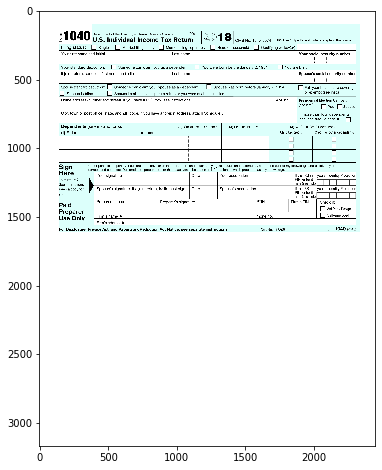

In [7]:
targetImage='f1040-001.png'
targetImage=os.path.join(PDFImages, targetImage)
im = Image.open(targetImage)
plt.figure(figsize=(12,8))
plt.imshow(np.array(im))

## 2. OCRing the whole image:

Now that we have an image of the page(s) of the PDF, Tesseract can transcribe all the text found on the images into .txt files

In [8]:
#save location:
PDFText=os.path.join(tempDir, 'PDFText')
try:
    os.mkdir(PDFText)
except:
    print('directory already exists. Cleaning out for next data run')
    for file in os.listdir(PDFText):
        os.remove(os.path.join(PDFText, file))
TextSave=os.path.join(PDFText,'.'.join(os.path.basename(targetImage).split('.')[:-1]))

In [9]:
for image in os.listdir(PDFImages):
    tesseractTarget=os.path.join(PDFImages, image)
    tesseractOutput=os.path.join(PDFText,'.'.join(image.split('.')[:-1]))
    p = os.popen('Tesseract\\tesseract.exe %s %s -l eng'%(tesseractTarget, tesseractOutput))

#### Looking at the extracted text:

In [10]:
os.listdir(PDFText)

['f1040-001.txt', 'f1040-002.txt']

In [11]:
extractedTextFull=open(os.path.join(PDFText,'f1040-001.txt')).read()

In [12]:
extractedTextFull='\n'.join([elm.strip() for elm in extractedTextFull.split('\n') if len(elm.strip())>0])
print(extractedTextFull)

Â£1040
Department of the Treasuryâ€”Internal Revenue Service
U.S. Individual Income Tax Return
(99)
2018
OMB No. 1545-0074 | IRS Use Onlyâ€”Do not write or staple in this space.
Filing status: [_] Single
LC] Married filing jointly LC] Married filing separately LC Head of household CL] Qualifying widow(er)
Your first name and initial
Last name
Your social security number
Your standard deduction:
CL Someone can claim you as a dependent
LE] You were born before January 2, 1954
| You are blind
If joint return, spouse's first name and initial
Last name
Spouseâ€™s social security number
Spouse standard deduction: CO Someone can claim your spouse as a dependent
L] Spouse is blind
CO Spouse was born before January 2, 1954
CL Spouse itemizes on a separate return or you were dual-status alien
EC] Full-year health care coverage
or exempt (see inst.)
Home address (number and street). If you have a P.O. box, see instructions.
Apt. no.
Presidential Election Campaign
(See inst.) [_] You [[] Spouse
Ci

# 3. Option to extract information between bookends:

If the form has instruction language, those instructions can be used to 'bookend' interesting data to extract. We can identify where 2 sections of instructions exist, and extract the text between. Using the print out of the extracted text above, I can identify bookend instruction language around a section of interest to extract.

In [13]:
bookend1="Last name"
bookend2="Your standard deduction:"

In [14]:
extractedTextFull.index(bookend1)

335

In [15]:
extractedTextFull.index(bookend2)

373

In [16]:
print(extractedTextFull[extractedTextFull.index(bookend1)+len(bookend1):extractedTextFull.index(bookend2)])


Your social security number



# 4. Clean up temp directory
Once everything has been completed, the temp files that were generated should be deleted.

In [17]:
for folder in ['PDFImages','PDFText']:
    try:
        for file in os.listdir(os.path.join(tempDir, folder)):
            os.remove(os.path.join(tempDir, folder,file))
        os.rmdir(os.path.join(tempDir, folder))
    except:
        print('Something went wrong with ',folder)
os.rmdir(tempDir)